# B-P Phoneme Data Preparation

Preparation of dataset for /b/ vs /p/ classification:
- Filter outliers (too short/long phonemes)
- Extract features: MFCC + ΔMFCC + formants + duration + energy
- Extract spectrogram windows (200ms) for CNN
- Quality assessment metrics
- Create optimized storage system for model training

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import librosa
import soundfile as sf
import json
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import Audio, display
import warnings
warnings.filterwarnings('ignore')
from concurrent.futures import ThreadPoolExecutor, as_completed
import os

# Try to import optional libraries
try:
    import h5py
    HAS_H5PY = True
except ImportError:
    HAS_H5PY = False
    print("Warning: h5py not installed. HDF5 storage will be unavailable.")

try:
    import parselmouth
    HAS_PARSELMOUTH = True
except ImportError:
    HAS_PARSELMOUTH = False
    print("Warning: parselmouth not installed. Will use LPC for formant extraction.")

from scipy import signal
from scipy.stats import zscore
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import IsolationForest
from sklearn.decomposition import PCA

# Configuration
# Determine project root (parent of notebooks directory)
PROJECT_ROOT = Path.cwd().parent if Path.cwd().name in ['notebooks', 'b-p_first_experiments'] else Path.cwd()
PHONEME_TBL = PROJECT_ROOT / 'artifacts' / 'phoneme_intervals.csv'
PHONEME_AUDIO = PROJECT_ROOT / 'artifacts' / 'phoneme_wav'
OUTPUT_DIR = PROJECT_ROOT / 'artifacts' / 'b-p_dataset'
OUTPUT_DIR.mkdir(parents=True, exist_ok=True)

# Feature extraction parameters
MIN_DURATION_MS = 25  # Minimum duration in milliseconds (forced for both B and P)
MAX_DURATION_MS = None  # None = auto via IQR
IQR_MULTIPLIER = 1.5
MFCC_N_COEFFS = 13
SPECTROGRAM_WINDOW_MS = 200
SAMPLE_SIZE = 20
PAUSE_MS = 300
STORAGE_FORMAT = 'parquet_h5'  # 'parquet_h5', 'parquet_embedded', 'pytorch'
SPECTROGRAM_FORMAT = 'h5'  # 'h5', 'npy', 'embedded'

# Audio processing parameters
SAMPLE_RATE = 16000
N_MELS = 128
HOP_LENGTH = 512

pd.options.display.max_rows = 30
pd.options.display.max_columns = None

print(f"Project root: {PROJECT_ROOT}")
print(f"Output directory: {OUTPUT_DIR}")
print(f"Storage format: {STORAGE_FORMAT}")


Project root: /Volumes/SSanDisk/SpeechRec-German
Output directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset
Storage format: parquet_h5


## 2. Load Data and Filter B/P Phonemes

In [2]:
# Load phoneme intervals table
print(f"Loading {PHONEME_TBL}...")
df_all = pd.read_csv(PHONEME_TBL)
print(f"Loaded {len(df_all):,} total phoneme intervals")

# Filter only /b/ and /p/ phonemes (exact match to exclude 'pf' and other variants)
df_bp = df_all[df_all['phoneme'].isin(['b', 'p'])].copy()
df_bp['class'] = df_bp['phoneme']  # Use phoneme directly as class (already 'b' or 'p')
print(f"\nFiltered to /b/ and /p/: {len(df_bp):,} phonemes")
print(f"  /b/: {len(df_bp[df_bp['class'] == 'b']):,}")
print(f"  /p/: {len(df_bp[df_bp['class'] == 'p']):,}")

# Create phoneme_id for each example
df_bp['phoneme_id'] = (
    df_bp['utterance_id'].astype(str) + '__' +
    df_bp['phoneme'].astype(str) + '__' +
    df_bp['start_ms'].astype(int).astype(str) + '_' +
    df_bp['end_ms'].astype(int).astype(str)
)

# Check which audio files exist
print("\nChecking audio file availability...")
audio_files = list(PHONEME_AUDIO.glob('*.wav'))
# Create dictionary with stem (filename without extension) as key
audio_dict = {f.stem: f for f in audio_files}
print(f"Found {len(audio_dict):,} audio files in {PHONEME_AUDIO}")

# Build expected filenames and check existence
# Format: {utt_id}__{mapped_phoneme}__{int(start_ms)}-{int(end_ms)}.wav
def get_expected_filename_stem(row):
    """Get expected filename stem (without .wav extension) for lookup."""
    return f"{row['utterance_id']}__{row['phoneme']}__{int(row['start_ms'])}-{int(row['end_ms'])}"

def get_expected_filename_full(row):
    """Get expected full filename (with .wav extension) for path."""
    return f"{row['utterance_id']}__{row['phoneme']}__{int(row['start_ms'])}-{int(row['end_ms'])}.wav"

df_bp['expected_filename_stem'] = df_bp.apply(get_expected_filename_stem, axis=1)
df_bp['expected_filename'] = df_bp.apply(get_expected_filename_full, axis=1)
df_bp['audio_exists'] = df_bp['expected_filename_stem'].apply(lambda x: x in audio_dict)
df_bp['audio_path'] = df_bp['expected_filename_stem'].apply(lambda x: audio_dict.get(x, None))

missing = (~df_bp['audio_exists']).sum()
print(f"Missing audio files: {missing:,} ({missing/len(df_bp)*100:.1f}%)")

# Keep only rows with existing audio files
df_bp = df_bp[df_bp['audio_exists']].copy()
print(f"\nFinal dataset size: {len(df_bp):,} phonemes with audio")
print(f"  /b/: {len(df_bp[df_bp['class'] == 'b']):,}")
print(f"  /p/: {len(df_bp[df_bp['class'] == 'p']):,}")

display(df_bp.head())


Loading /Volumes/SSanDisk/SpeechRec-German/artifacts/phoneme_intervals.csv...
Loaded 1,337,749 total phoneme intervals

Filtered to /b/ and /p/: 36,903 phonemes
  /b/: 25,874
  /p/: 11,029

Checking audio file availability...
Found 1,327,745 audio files in /Volumes/SSanDisk/SpeechRec-German/artifacts/phoneme_wav
Missing audio files: 0 (0.0%)

Final dataset size: 36,903 phonemes with audio
  /b/: 25,874
  /p/: 11,029


,utterance_id,phoneme,start_ms,end_ms,duration_ms,class,phoneme_id,expected_filename_stem,expected_filename,audio_exists,audio_path
22,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,b,2200.0,2240.0,40.0,b,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,4aeeae88-0777-2c8c-5c93-2e844a462e49---4783573...,True,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...
31,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,b,380.0,480.0,100.0,b,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,True,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...
42,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,b,1730.0,1800.0,70.0,b,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,True,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...
46,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,b,2010.0,2140.0,130.0,b,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,True,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...
74,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,b,4040.0,4080.0,40.0,b,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,True,/Volumes/SSanDisk/SpeechRec-German/artifacts/p...


## 3. Filter Outliers by Duration

Duration statistics by class:


,count,mean,std,min,25%,50%,75%,max
class,,,,,,,,
b,25874.0,68.165726,26.750720,10.0,50.0,60.0,80.0,340.0
p,11029.0,104.324689,34.697415,10.0,80.0,100.0,120.0,320.0


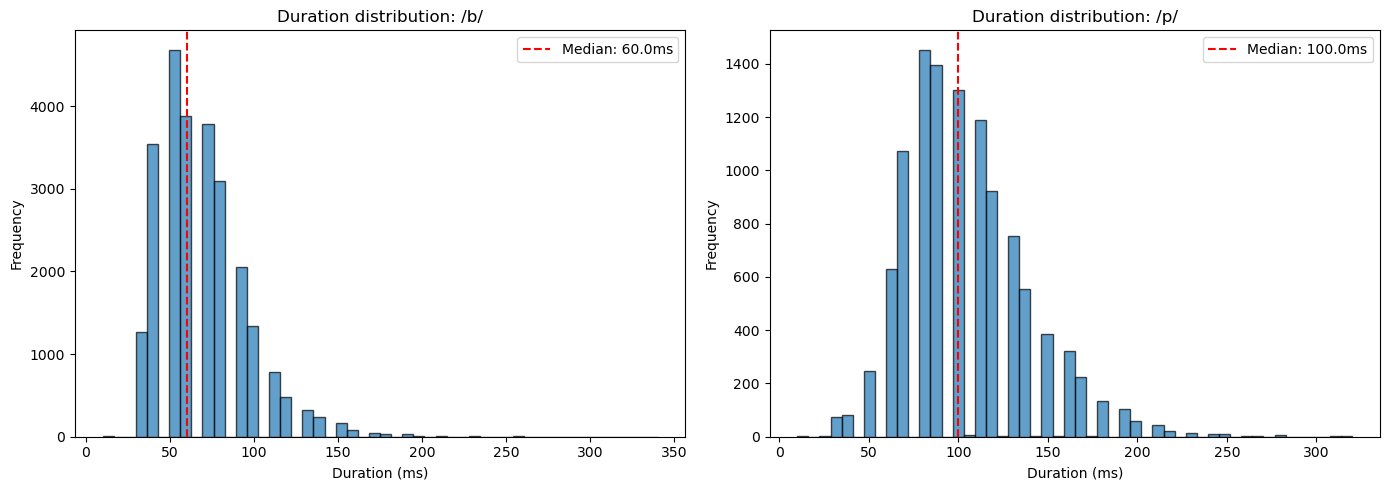


/b/ duration thresholds (IQR method):
  Q1: 50.0ms, Q3: 80.0ms, IQR: 30.0ms
  Lower bound: 5.0ms
  Upper bound: 125.0ms

/p/ duration thresholds (IQR method):
  Q1: 80.0ms, Q3: 120.0ms, IQR: 40.0ms
  Lower bound: 20.0ms
  Upper bound: 180.0ms

Using manual thresholds:
  MIN_DURATION_MS: 25
  MAX_DURATION_MS: None

/b/ outliers: 957 (removed)

/p/ outliers: 286 (removed)

After filtering outliers:
  Original: 36,903 phonemes
  Filtered: 35,660 phonemes
  Removed: 1,243 phonemes

By class:
  /b/: 24,917
  /p/: 10,743


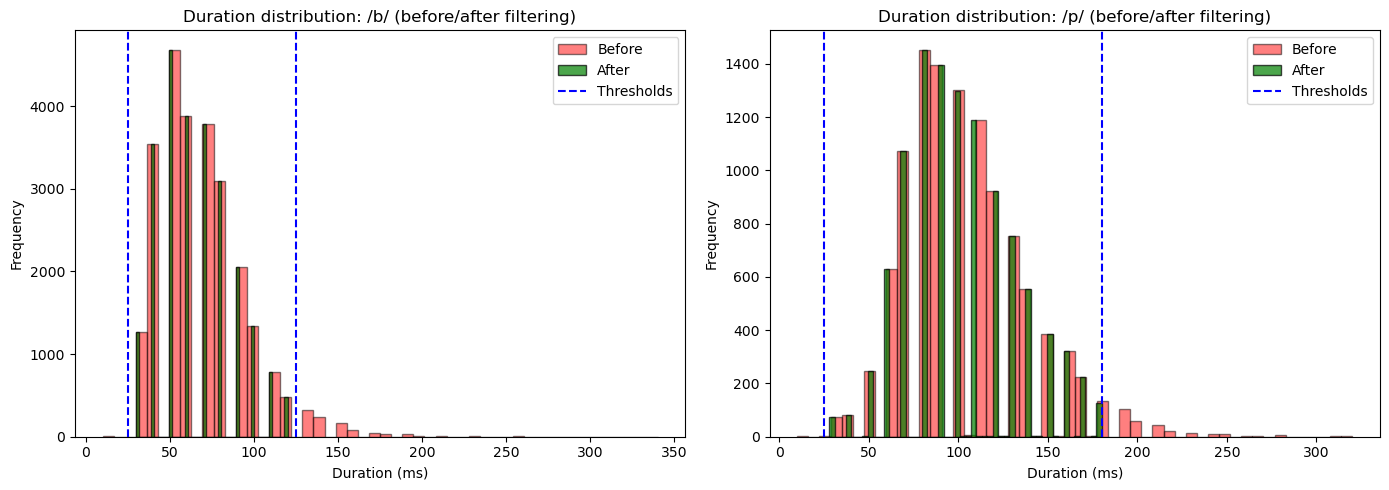

In [3]:
# Duration statistics by class
print("Duration statistics by class:")
duration_stats = df_bp.groupby('class')['duration_ms'].describe()
display(duration_stats)

# Visualize duration distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, phoneme in enumerate(['b', 'p']):
    durations = df_bp[df_bp['class'] == phoneme]['duration_ms']
    axes[idx].hist(durations, bins=50, alpha=0.7, edgecolor='black')
    axes[idx].set_title(f'Duration distribution: /{phoneme}/')
    axes[idx].set_xlabel('Duration (ms)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(durations.median(), color='red', linestyle='--', label=f'Median: {durations.median():.1f}ms')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Calculate IQR-based thresholds for each class
def calculate_iqr_thresholds(durations, multiplier=IQR_MULTIPLIER):
    Q1 = durations.quantile(0.25)
    Q3 = durations.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - multiplier * IQR
    upper_bound = Q3 + multiplier * IQR
    return lower_bound, upper_bound, Q1, Q3, IQR

thresholds = {}
for phoneme in ['b', 'p']:
    durations = df_bp[df_bp['class'] == phoneme]['duration_ms']
    lower, upper, Q1, Q3, IQR = calculate_iqr_thresholds(durations)
    thresholds[phoneme] = {
        'lower': lower,
        'upper': upper,
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR
    }
    print(f"\n/{phoneme}/ duration thresholds (IQR method):")
    print(f"  Q1: {Q1:.1f}ms, Q3: {Q3:.1f}ms, IQR: {IQR:.1f}ms")
    print(f"  Lower bound: {lower:.1f}ms")
    print(f"  Upper bound: {upper:.1f}ms")

# Apply manual thresholds if specified, otherwise use IQR
if MIN_DURATION_MS is not None or MAX_DURATION_MS is not None:
    print(f"\nUsing manual thresholds:")
    print(f"  MIN_DURATION_MS: {MIN_DURATION_MS}")
    print(f"  MAX_DURATION_MS: {MAX_DURATION_MS}")
    for phoneme in ['b', 'p']:
        thresholds[phoneme]['lower'] = MIN_DURATION_MS if MIN_DURATION_MS is not None else thresholds[phoneme]['lower']
        thresholds[phoneme]['upper'] = MAX_DURATION_MS if MAX_DURATION_MS is not None else thresholds[phoneme]['upper']

# Filter outliers
df_bp['is_outlier'] = False
for phoneme in ['b', 'p']:
    mask = df_bp['class'] == phoneme
    lower = thresholds[phoneme]['lower']
    upper = thresholds[phoneme]['upper']
    outliers = mask & ((df_bp['duration_ms'] < lower) | (df_bp['duration_ms'] > upper))
    df_bp.loc[outliers, 'is_outlier'] = True
    print(f"\n/{phoneme}/ outliers: {outliers.sum():,} (removed)")

df_bp_filtered = df_bp[~df_bp['is_outlier']].copy()
print(f"\nAfter filtering outliers:")
print(f"  Original: {len(df_bp):,} phonemes")
print(f"  Filtered: {len(df_bp_filtered):,} phonemes")
print(f"  Removed: {len(df_bp) - len(df_bp_filtered):,} phonemes")
print(f"\nBy class:")
print(f"  /b/: {len(df_bp_filtered[df_bp_filtered['class'] == 'b']):,}")
print(f"  /p/: {len(df_bp_filtered[df_bp_filtered['class'] == 'p']):,}")

# Visualize after filtering
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

for idx, phoneme in enumerate(['b', 'p']):
    durations_before = df_bp[df_bp['class'] == phoneme]['duration_ms']
    durations_after = df_bp_filtered[df_bp_filtered['class'] == phoneme]['duration_ms']
    
    axes[idx].hist(durations_before, bins=50, alpha=0.5, label='Before', color='red', edgecolor='black')
    axes[idx].hist(durations_after, bins=50, alpha=0.7, label='After', color='green', edgecolor='black')
    axes[idx].set_title(f'Duration distribution: /{phoneme}/ (before/after filtering)')
    axes[idx].set_xlabel('Duration (ms)')
    axes[idx].set_ylabel('Frequency')
    axes[idx].axvline(thresholds[phoneme]['lower'], color='blue', linestyle='--', label='Thresholds')
    axes[idx].axvline(thresholds[phoneme]['upper'], color='blue', linestyle='--')
    axes[idx].legend()

plt.tight_layout()
plt.show()

# Update dataframe
df_bp = df_bp_filtered.copy()


In [4]:
def extract_mfcc_features(audio, sr=SAMPLE_RATE, n_mfcc=MFCC_N_COEFFS):
    """Extract MFCC features and their deltas."""
    mfcc = librosa.feature.mfcc(y=audio, sr=sr, n_mfcc=n_mfcc, hop_length=HOP_LENGTH)
    
    # Handle short audio files: adjust delta width based on available frames
    n_frames = mfcc.shape[1]
    default_width = 9
    
    # For delta features, use adaptive width or mode='nearest' for very short sequences
    if n_frames < default_width:
        # Use mode='nearest' for very short sequences (no interpolation needed)
        # Calculate width: must be odd integer >= 3
        # For very short sequences, use minimum width of 3
        # Note: with mode='nearest', width can be > n_frames
        if n_frames < 3:
            # For extremely short sequences, use width=3 (minimum allowed)
            # mode='nearest' will handle padding
            calculated_width = 3
        elif n_frames < 9:
            # Use largest odd number <= n_frames, but at least 3
            calculated_width = n_frames if n_frames % 2 == 1 else n_frames - 1
            calculated_width = max(3, calculated_width)
        else:
            calculated_width = 9
        # Ensure width is odd
        if calculated_width % 2 == 0:
            calculated_width = max(3, calculated_width - 1)
        delta_mfcc = librosa.feature.delta(mfcc, width=calculated_width, mode='nearest')
        delta2_mfcc = librosa.feature.delta(mfcc, order=2, width=calculated_width, mode='nearest')
    else:
        # Use default interpolation for longer sequences
        delta_mfcc = librosa.feature.delta(mfcc)
        delta2_mfcc = librosa.feature.delta(mfcc, order=2)
    
    return {
        'mfcc_mean': np.mean(mfcc, axis=1),
        'mfcc_std': np.std(mfcc, axis=1),
        'delta_mfcc_mean': np.mean(delta_mfcc, axis=1),
        'delta_mfcc_std': np.std(delta_mfcc, axis=1),
        'delta2_mfcc_mean': np.mean(delta2_mfcc, axis=1),
        'delta2_mfcc_std': np.std(delta2_mfcc, axis=1),
    }

def extract_energy_features(audio, sr=SAMPLE_RATE):
    """Extract energy-related features."""
    rms = librosa.feature.rms(y=audio, hop_length=HOP_LENGTH)[0]
    zcr = librosa.feature.zero_crossing_rate(audio, hop_length=HOP_LENGTH)[0]
    
    return {
        'energy_rms': np.mean(rms),
        'energy_rms_std': np.std(rms),
        'energy_zcr': np.mean(zcr),
        'energy_zcr_std': np.std(zcr),
    }

def extract_spectral_features(audio, sr=SAMPLE_RATE):
    """Extract spectral features."""
    centroid = librosa.feature.spectral_centroid(y=audio, sr=sr, hop_length=HOP_LENGTH)[0]
    rolloff = librosa.feature.spectral_rolloff(y=audio, sr=sr, hop_length=HOP_LENGTH)[0]
    bandwidth = librosa.feature.spectral_bandwidth(y=audio, sr=sr, hop_length=HOP_LENGTH)[0]
    contrast = librosa.feature.spectral_contrast(y=audio, sr=sr, hop_length=HOP_LENGTH)
    
    return {
        'spectral_centroid': np.mean(centroid),
        'spectral_centroid_std': np.std(centroid),
        'spectral_rolloff': np.mean(rolloff),
        'spectral_rolloff_std': np.std(rolloff),
        'spectral_bandwidth': np.mean(bandwidth),
        'spectral_bandwidth_std': np.std(bandwidth),
        'spectral_contrast_mean': np.mean(contrast, axis=1),
    }

def extract_formants_lpc(audio, sr=SAMPLE_RATE, n_formants=4, order=10):
    # #region agent log
    import json; log_data = {'location': 'extract_formants_lpc:start', 'message': 'Starting formant extraction', 'data': {'audio_len': len(audio), 'sr': sr, 'n_formants': n_formants}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'A'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
    # #endregion
    """Extract formants using LPC (Linear Predictive Coding)."""
    # Pre-emphasis filter
    audio_pre = signal.lfilter([1, -0.97], 1, audio)
    
    # Frame the signal
    frame_length = int(0.025 * sr)  # 25ms frames
    hop_length_frame = int(0.010 * sr)  # 10ms hop
    
    formants_list = []
    
    for i in range(0, len(audio_pre) - frame_length, hop_length_frame):
        frame = audio_pre[i:i+frame_length]
        
        # Apply window
        windowed = frame * signal.windows.hann(len(frame))
        
        # LPC analysis using Levinson-Durbin algorithm (compatible with older scipy versions)
        try:
            # Compute autocorrelation
            autocorr = np.correlate(windowed, windowed, mode='full')
            autocorr = autocorr[len(autocorr)//2:len(autocorr)//2+order+1]
            
            # Levinson-Durbin recursion
            a = np.zeros(order + 1)
            a[0] = 1.0
            e = autocorr[0]
            
            for j in range(1, order + 1):
                # Compute reflection coefficient
                k = -np.sum(a[:j] * autocorr[j:0:-1]) / e
                
                # Update coefficients
                a[1:j+1] = a[1:j+1] + k * a[j-1::-1]
                a[j] = k
                
                # Update error
                e = e * (1 - k * k)
            roots = np.roots(a)
            roots = roots[np.imag(roots) >= 0]
            angles = np.angle(roots)
            # #region agent log
            log_data = {'location': 'extract_formants_lpc:freq_calc', 'message': 'Before frequency calculation', 'data': {'angles': angles.tolist()[:10] if len(angles) > 0 else [], 'n_angles': len(angles)}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'B'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
            # #endregion
            # Convert angles to frequencies
            freqs = angles * (sr / (2 * np.pi))
            # Get magnitudes of roots for filtering
            magnitudes = np.abs(roots)
            # #region agent log
            import json; log_data = {'location': 'extract_formants_lpc:before_filter', 'message': 'Before filtering', 'data': {'n_freqs': len(freqs), 'freqs_sample': freqs[:5].tolist() if len(freqs) > 0 else [], 'magnitudes_sample': magnitudes[:5].tolist() if len(magnitudes) > 0 else [], 'max_magnitude': float(np.max(magnitudes)) if len(magnitudes) > 0 else 0.0, 'min_magnitude': float(np.min(magnitudes)) if len(magnitudes) > 0 else 0.0, 'freqs_in_range': len([f for f in freqs if 50 < f < sr/2]), 'magnitudes_above_07': len([m for m in magnitudes if m > 0.7])}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'A'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
            # #endregion
            # Filter: formants should have high magnitude (close to unit circle) and be in valid frequency range
            # Sort by magnitude (descending) to prioritize strong formants
            freq_mag_pairs = [(f, m) for f, m in zip(freqs, magnitudes) if 50 < f < sr/2 and m > 0.7]
            freq_mag_pairs.sort(key=lambda x: x[1], reverse=True)  # Sort by magnitude
            freqs = [f for f, m in freq_mag_pairs]
            # #region agent log
            import json; log_data = {'location': 'extract_formants_lpc:after_filter', 'message': 'After filtering', 'data': {'freqs': freqs[:10] if len(freqs) > 0 else [], 'n_freqs': len(freqs), 'freq_mag_pairs_sample': [(float(f), float(m)) for f, m in freq_mag_pairs[:5]] if len(freq_mag_pairs) > 0 else []}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'B'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
            # #endregion
            
            # Extract formants (peaks in frequency response)
            # Extract formants (already filtered and sorted by magnitude)
            formants = freqs[:n_formants]  # Take top n_formants by magnitude
            
            # Pad if needed
            while len(formants) < n_formants:
                formants.append(0.0)
            
            formants_list.append(formants[:n_formants])
            # #region agent log
            import json; log_data = {'location': 'extract_formants_lpc:frame_result', 'message': 'Frame formants extracted', 'data': {'formants': formants[:n_formants], 'n_formants': len(formants)}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'C'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
            # #endregion
        except Exception as e:
            # #region agent log
            import json; log_data = {'location': 'extract_formants_lpc:frame_error', 'message': 'Error in frame processing', 'data': {'error': str(e)}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'E'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
            # #endregion
            formants_list.append([0.0] * n_formants)
    
    if len(formants_list) == 0:
        return {
        'formant_f1': 0.0, 'formant_f2': 0.0, 'formant_f3': 0.0, 'formant_f4': 0.0,
        'formant_f1_std': 0.0, 'formant_f2_std': 0.0, 'formant_f3_std': 0.0, 'formant_f4_std': 0.0,
        }
    
    formants_array = np.array(formants_list)

    # #region agent log
    import json; log_data = {'location': 'extract_formants_lpc:final', 'message': 'Final formant values', 'data': {'formants_array_shape': list(formants_array.shape) if len(formants_array) > 0 else [], 'n_frames': len(formants_list), 'f1_mean': float(np.mean(formants_array[:, 0])) if len(formants_array) > 0 else 0.0, 'f1_any': bool(np.any(formants_array[:, 0] > 0)) if len(formants_array) > 0 else False, 'f1_max': float(np.max(formants_array[:, 0])) if len(formants_array) > 0 else 0.0, 'f1_min': float(np.min(formants_array[:, 0])) if len(formants_array) > 0 else 0.0, 'f2_mean': float(np.mean(formants_array[:, 1])) if len(formants_array) > 0 else 0.0, 'f2_any': bool(np.any(formants_array[:, 1] > 0)) if len(formants_array) > 0 else False, 'f2_max': float(np.max(formants_array[:, 1])) if len(formants_array) > 0 else 0.0, 'f2_min': float(np.min(formants_array[:, 1])) if len(formants_array) > 0 else 0.0, 'f1_nonzero_count': int(np.sum(formants_array[:, 0] > 0)) if len(formants_array) > 0 else 0, 'f2_nonzero_count': int(np.sum(formants_array[:, 1] > 0)) if len(formants_array) > 0 else 0}, 'timestamp': __import__('time').time() * 1000, 'sessionId': 'debug-session', 'runId': 'run1', 'hypothesisId': 'D'}; open('/Volumes/SSanDisk/SpeechRec-German/.cursor/debug.log', 'a').write(json.dumps(log_data) + '\n')
    # #endregion


    
    return {
    
        'formant_f1': np.mean(formants_array[:, 0]) if len(formants_array) > 0 and np.any(formants_array[:, 0] > 0) else 0.0,
        'formant_f2': np.mean(formants_array[:, 1]) if len(formants_array) > 0 and np.any(formants_array[:, 1] > 0) else 0.0,
        'formant_f3': np.mean(formants_array[:, 2]) if len(formants_array) > 0 and np.any(formants_array[:, 2] > 0) else 0.0,
        'formant_f4': np.mean(formants_array[:, 3]) if len(formants_array) > 0 and np.any(formants_array[:, 3] > 0) else 0.0,
        'formant_f1_std': np.std(formants_array[:, 0]) if len(formants_array) > 0 and np.any(formants_array[:, 0] > 0) else 0.0,
        'formant_f2_std': np.std(formants_array[:, 1]) if len(formants_array) > 0 and np.any(formants_array[:, 1] > 0) else 0.0,
        'formant_f3_std': np.std(formants_array[:, 2]) if len(formants_array) > 0 and np.any(formants_array[:, 2] > 0) else 0.0,
        'formant_f4_std': np.std(formants_array[:, 3]) if len(formants_array) > 0 and np.any(formants_array[:, 3] > 0) else 0.0,
    }

def extract_formants_parselmouth(audio, sr=SAMPLE_RATE, n_formants=4):
    """Extract formants using Parselmouth (Praat)."""
    if not HAS_PARSELMOUTH:
        return extract_formants_lpc(audio, sr, n_formants)
    
    try:
        sound = parselmouth.Sound(audio, sampling_frequency=sr)
        formant = sound.to_formant_burg(time_step=0.01)
        
        formants_list = []
        times = np.arange(0, sound.duration, 0.01)
        
        for t in times:
            formants = []
            for i in range(1, n_formants + 1):
                try:
                    f = formant.get_value_at_time(i, t)
                    if f > 0:
                        formants.append(f)
                    else:
                        formants.append(0.0)
                except:
                    formants.append(0.0)
            formants_list.append(formants)
        
        formants_array = np.array(formants_list)

        return {
        }

        return {

        
    }
    except Exception as e:
        print(f"Parselmouth formant extraction failed: {e}, falling back to LPC")
        return extract_formants_lpc(audio, sr, n_formants)

def extract_quality_metrics(audio, sr=SAMPLE_RATE):
    """Extract quality metrics for noise assessment."""
    # Spectral flatness (measure of noisiness)
    stft = librosa.stft(audio, hop_length=HOP_LENGTH)
    magnitude = np.abs(stft)
    
    # Avoid division by zero
    magnitude = magnitude + 1e-10
    
    geometric_mean = np.exp(np.mean(np.log(magnitude), axis=0))
    arithmetic_mean = np.mean(magnitude, axis=0)
    spectral_flatness = geometric_mean / (arithmetic_mean + 1e-10)
    spectral_flatness_mean = np.mean(spectral_flatness)
    
    # Harmonic-to-noise ratio approximation
    harmonic = librosa.effects.harmonic(audio)
    percussive = librosa.effects.percussive(audio)
    hnr = np.mean(harmonic**2) / (np.mean(percussive**2) + 1e-10)
    
    # Zero-crossing rate (high = noise)
    zcr = librosa.feature.zero_crossing_rate(audio, hop_length=HOP_LENGTH)[0]
    zcr_mean = np.mean(zcr)
    
    # Energy distribution (uniform = noise)
    rms = librosa.feature.rms(y=audio, hop_length=HOP_LENGTH)[0]
    energy_std = np.std(rms)
    energy_mean = np.mean(rms)
    energy_cv = energy_std / (energy_mean + 1e-10)  # Coefficient of variation
    
    return {
        'spectral_flatness': spectral_flatness_mean,
        'harmonic_noise_ratio': hnr,
        'zcr_mean': zcr_mean,
        'energy_cv': energy_cv,
    }

def extract_all_features(audio_path, sr=SAMPLE_RATE):
    """Extract all features from an audio file."""
    try:
        audio, _ = librosa.load(audio_path, sr=sr, mono=True)
        
        features = {}
        features.update(extract_mfcc_features(audio, sr))
        features.update(extract_energy_features(audio, sr))
        features.update(extract_spectral_features(audio, sr))
        
        # Use Parselmouth if available, otherwise LPC
        if HAS_PARSELMOUTH:
            features.update(extract_formants_parselmouth(audio, sr))
        else:
            features.update(extract_formants_lpc(audio, sr))
        
        features.update(extract_quality_metrics(audio, sr))
        
        return features
    except Exception as e:
        print(f"Error extracting features from {audio_path}: {e}")
        return None

print("Feature extraction functions defined.")


Feature extraction functions defined.


## 5. Extract Features for All Phonemes

In [5]:
# Extract features for all phonemes
# Set MAX_PHONEMES to None to process all, or set a number (e.g., 20) for quick testing
MAX_PHONEMES = None  # Change to 20 for quick testing

df_to_process = df_bp.head(MAX_PHONEMES) if MAX_PHONEMES is not None else df_bp
print(f"Extracting features for {len(df_to_process):,} phonemes{' (LIMITED FOR TESTING)' if MAX_PHONEMES is not None else ''}...")

# Helper function for parallel processing
def process_single_phoneme(row_data):
    """Process a single phoneme row and extract features."""
    idx, row = row_data
    audio_path = row['audio_path']
    if audio_path is None or not Path(audio_path).exists():
        return None
    
    features = extract_all_features(audio_path)
    if features is not None:
        features['phoneme_id'] = row['phoneme_id']
        features['class'] = row['class']
        features['duration_ms'] = row['duration_ms']
    return features

# Use parallel processing with all available CPU cores
num_workers = os.cpu_count() or 4
print(f"Using {num_workers} parallel workers...")

features_list = []

# Prepare data for parallel processing
rows_to_process = [(idx, row) for idx, row in df_to_process.iterrows()]

# Use ThreadPoolExecutor (works reliably in Jupyter)
# Note: ThreadPoolExecutor uses threads, not processes, so it works around GIL limitations.
# However, librosa and scipy internally use OpenMP/BLAS which can utilize multiple cores.
print("Using ThreadPoolExecutor for parallel processing...")
with ThreadPoolExecutor(max_workers=num_workers) as executor:
    future_to_row = {executor.submit(process_single_phoneme, row_data): row_data 
                  for row_data in rows_to_process}
    
    for future in tqdm(as_completed(future_to_row), total=len(future_to_row), desc="Extracting features"):
        try:
            features = future.result()
            if features is not None:
                features_list.append(features)
        except Exception as e:
            idx, row = future_to_row[future]
            print(f"Error processing phoneme {row.get('phoneme_id', 'unknown')}: {e}")

print(f"\nExtracted features for {len(features_list):,} phonemes")

# Convert to DataFrame
df_features = pd.DataFrame(features_list)
print(f"\nFeature columns: {len(df_features.columns)}")
print(f"Feature shape: {df_features.shape}")

# Expand array columns into separate columns
# Arrays like mfcc_mean (13 elements) need to be expanded into mfcc_mean_0, mfcc_mean_1, etc.
array_columns = []
for col in df_features.columns:
    if df_features[col].dtype == 'object':
        # Check if column contains arrays
        sample = df_features[col].iloc[0] if len(df_features) > 0 else None
        if sample is not None and isinstance(sample, np.ndarray):
            array_columns.append(col)

# Expand array columns
for col in array_columns:
    # Get the length of arrays (should be consistent)
    array_length = len(df_features[col].iloc[0])
    # Create new columns for each element
    for i in range(array_length):
        new_col_name = f"{col}_{i}"
        df_features[new_col_name] = df_features[col].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else np.nan)
    # Drop the original array column
    df_features = df_features.drop(columns=[col])

print(f"\nAfter expanding arrays: {len(df_features.columns)} columns")
print(f"Feature shape: {df_features.shape}")

display(df_features.head())


Extracting features for 35,660 phonemes...
Using 8 parallel workers...
Using ThreadPoolExecutor for parallel processing...


Extracting features: 100%|██████████| 35660/35660 [05:38<00:00, 105.29it/s]



Extracted features for 35,660 phonemes

Feature columns: 32
Feature shape: (35660, 32)

After expanding arrays: 110 columns
Feature shape: (35660, 110)


,energy_rms,energy_rms_std,energy_zcr,energy_zcr_std,spectral_centroid,spectral_centroid_std,spectral_rolloff,spectral_rolloff_std,spectral_bandwidth,spectral_bandwidth_std,formant_f1,formant_f2,formant_f3,formant_f4,formant_f1_std,formant_f2_std,formant_f3_std,formant_f4_std,spectral_flatness,harmonic_noise_ratio,zcr_mean,energy_cv,phoneme_id,class,duration_ms,mfcc_mean_0,mfcc_mean_1,mfcc_mean_2,mfcc_mean_3,mfcc_mean_4,mfcc_mean_5,mfcc_mean_6,mfcc_mean_7,mfcc_mean_8,mfcc_mean_9,mfcc_mean_10,mfcc_mean_11,mfcc_mean_12,mfcc_std_0,mfcc_std_1,mfcc_std_2,mfcc_std_3,mfcc_std_4,mfcc_std_5,mfcc_std_6,mfcc_std_7,mfcc_std_8,mfcc_std_9,mfcc_std_10,mfcc_std_11,mfcc_std_12,delta_mfcc_mean_0,delta_mfcc_mean_1,delta_mfcc_mean_2,delta_mfcc_mean_3,delta_mfcc_mean_4,delta_mfcc_mean_5,delta_mfcc_mean_6,delta_mfcc_mean_7,delta_mfcc_mean_8,delta_mfcc_mean_9,delta_mfcc_mean_10,delta_mfcc_mean_11,delta_mfcc_mean_12,delta_mfcc_std_0,delta_mfcc_std_1,delta_mfcc_std_2,delta_mfcc_std_3,delta_mfcc_std_4,delta_mfcc_std_5,delta_mfcc_std_6,delta_mfcc_std_7,delta_mfcc_std_8,delta_mfcc_std_9,delta_mfcc_std_10,delta_mfcc_std_11,delta_mfcc_std_12,delta2_mfcc_mean_0,delta2_mfcc_mean_1,delta2_mfcc_mean_2,delta2_mfcc_mean_3,delta2_mfcc_mean_4,delta2_mfcc_mean_5,delta2_mfcc_mean_6,delta2_mfcc_mean_7,delta2_mfcc_mean_8,delta2_mfcc_mean_9,delta2_mfcc_mean_10,delta2_mfcc_mean_11,delta2_mfcc_mean_12,delta2_mfcc_std_0,delta2_mfcc_std_1,delta2_mfcc_std_2,delta2_mfcc_std_3,delta2_mfcc_std_4,delta2_mfcc_std_5,delta2_mfcc_std_6,delta2_mfcc_std_7,delta2_mfcc_std_8,delta2_mfcc_std_9,delta2_mfcc_std_10,delta2_mfcc_std_11,delta2_mfcc_std_12,spectral_contrast_mean_0,spectral_contrast_mean_1,spectral_contrast_mean_2,spectral_contrast_mean_3,spectral_contrast_mean_4,spectral_contrast_mean_5,spectral_contrast_mean_6
0,0.003811,0.000000,0.012695,0.000000,980.560658,64.370642,2054.687500,171.875000,1504.033175,39.853854,396.806048,5977.584090,3911.442852,3277.492999,112.089857,936.825516,1500.651583,327.627392,0.266858,3.081665,0.012695,0.000000,dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addc...,b,40.0,-434.398834,130.104782,17.749422,31.460007,6.075728,7.392363,0.328892,6.837136,-3.656724,-5.579247,-4.282049,-5.152533,4.045979,18.359161,2.560196,8.908705,2.132050,5.151580,0.676962,3.614007,0.078257,3.892839,2.542232,0.369880,2.966870,0.339518,18.359161,2.560196,-8.908706,-2.132050,-5.151580,-0.676962,-3.614007,0.078257,-3.892839,-2.542232,-0.369880,-2.966870,-0.339518,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,-9.536743e-07,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,36.718323,5.120392,17.817410,4.264099,10.303161,1.353924,7.228014,0.156513,7.785677,5.084465,0.739761,5.933740,0.679037,10.994079,11.310481,12.093902,14.834366,14.513775,14.042383,10.506210
1,0.010381,0.000000,0.019043,0.000000,1693.222574,40.682346,3828.125000,62.500000,1706.852592,28.239167,943.521462,5555.322589,3875.210242,3537.093696,584.263042,1295.050916,1409.556752,1574.051163,0.411129,NaN,0.019043,0.000000,4aeeae88-0777-2c8c-5c93-2e844a462e49---3291ab0...,b,40.0,-290.198486,88.500786,-11.054476,41.520161,25.663048,25.109356,-34.974163,-9.576468,-6.953031,1.651763,5.262284,-19.743036,-12.092075,39.071854,2.939445,3.530263,4.907436,1.089282,2.247280,3.907146,1.713195,2.271190,0.014673,0.188948,0.952770,0.750282,39.071854,2.939445,3.530263,-4.907436,-1.089282,-2.247280,3.907146,1.713195,2.271190,0.014673,-0.188948,0.952770,0.750282,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,0.0,0.0,0.0,0.000000e+00,0.000000e+00,78.143707,5.878891,7.060526,9.814873,2.178564,4.494560,7.814291,3.426389,4.542380,0.029345,0.377895,1.905540,1.500564,12.340752,10.574339,15.452712,15.552695,15.730120,15.578438,9.341458
2,0.006168,0.000000,0.048828,0.000000,1892.761221,3.859370,3343.750000,7.812500

## 6. Extract Spectrograms for CNN

In [6]:
def extract_spectrogram_window(audio_path, target_duration_ms=SPECTROGRAM_WINDOW_MS, sr=SAMPLE_RATE):
    """Extract mel-spectrogram with fixed window size."""
    try:
        audio, _ = librosa.load(audio_path, sr=sr, mono=True)
        audio_duration_ms = len(audio) / sr * 1000
        
        # If audio is shorter than target, pad with zeros
        target_samples = int(target_duration_ms / 1000 * sr)
        
        if len(audio) < target_samples:
            # Pad with zeros
            padding = target_samples - len(audio)
            audio = np.pad(audio, (0, padding), mode='constant')
        elif len(audio) > target_samples:
            # Trim to target length
            audio = audio[:target_samples]
        
        # Extract mel-spectrogram
        mel_spec = librosa.feature.melspectrogram(
            y=audio, 
            sr=sr, 
            n_mels=N_MELS, 
            hop_length=HOP_LENGTH,
            fmax=sr/2
        )
        
        # Convert to dB
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        return mel_spec_db
    except Exception as e:
        print(f"Error extracting spectrogram from {audio_path}: {e}")
        return None

# Extract spectrograms
print(f"Extracting spectrograms for {len(df_bp):,} phonemes...")
spectrograms = {}

for idx, row in tqdm(df_bp.iterrows(), total=len(df_bp), desc="Extracting spectrograms"):
    audio_path = row['audio_path']
    phoneme_id = row['phoneme_id']
    
    if audio_path is None or not Path(audio_path).exists():
        continue
    
    spec = extract_spectrogram_window(audio_path)
    if spec is not None:
        spectrograms[phoneme_id] = spec

print(f"\nExtracted {len(spectrograms):,} spectrograms")
print(f"Spectrogram shape: {list(spectrograms.values())[0].shape if spectrograms else 'N/A'}")


Extracting spectrograms for 35,660 phonemes...


Extracting spectrograms: 100%|██████████| 35660/35660 [01:03<00:00, 557.29it/s]


Extracted 35,660 spectrograms
Spectrogram shape: (128, 7)


## 7. Quality Assessment and Outlier Detection

Merged dataset: 35,660 phonemes

Performing outlier detection using Isolation Forest...
Detected 3,566 outliers via Isolation Forest (10.0%)


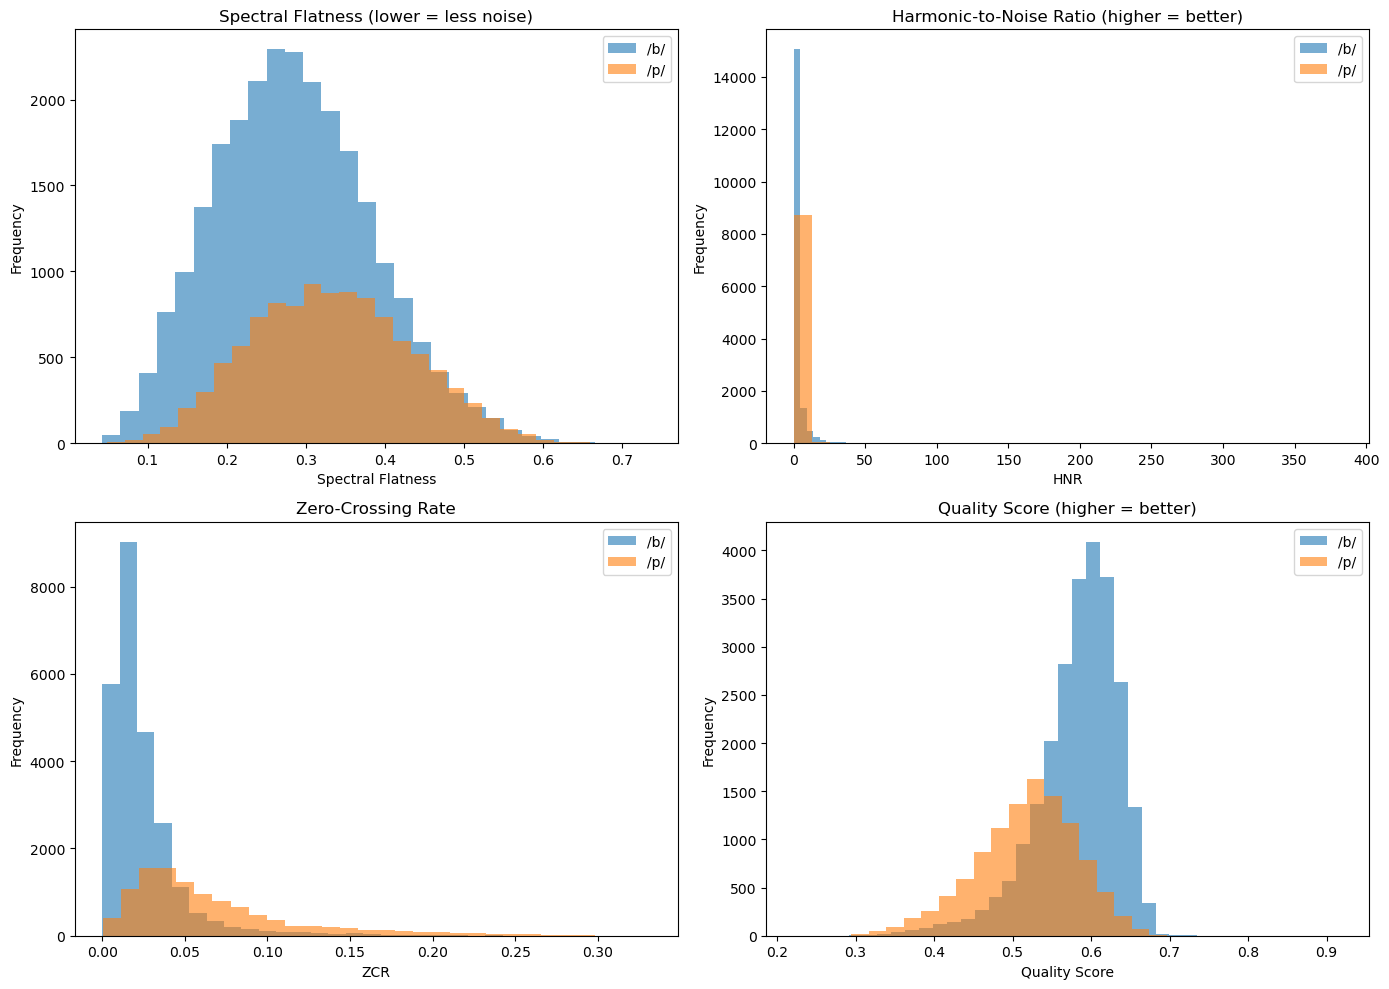


Quality metrics summary by class:


spectral_flatness                                                    \
                  count      mean       std       min       25%       50%   
class                                                                       
b               24917.0  0.285150  0.098876  0.042498  0.213465  0.280317   
p               10743.0  0.332296  0.099811  0.048404  0.258407  0.329137   

                          harmonic_noise_ratio                      \
            75%       max                count      mean       std   
class                                                                
b      0.350304  0.735502              17498.0  2.492337  5.913848   
p      0.401245  0.726711               8769.0  1.125729  4.993103   

                                                              zcr_mean  \
                min       25%       50%       75%         max    count   
class                                                                    
b      8.634058e-07  0.148713  0.652117  2.403141  135.990189  24917.0   
p      3.675634e-05  0.121266  0.378368  1.026668  382.901123  10743.0   

                                                                             \
           mean       std       min       25%       50%       75%       max   
class                                                                         
b      0.024277  0.023369  0.000000  0.010742  0.017415  0.029460  0.316081   
p      0.066731  0.051344  0.000488  0.031543  0.051562  0.085449  0.331706   

      energy_cv                                                         \
          count      mean       std  min       25%       50%       75%   
class                                                                    
b       24917.0  0.106347  0.174922  0.0  0.000000  0.000000  0.157822   
p       10743.0  0.254778  0.198825  0.0  0.067241  0.237192  0.410359   

                quality_score                                          \
            max         count      mean       std       min       25%   
class                                                                   
b      0.984322       24917.0  0.583388  0.052729  0.221085  0.558006   
p      1.179433       10743.0  0.517737  0.064210  0.250065  0.478005   

                                     
            50%       75%       max  
class                                
b      0.592256  0.619376  0.753117  
p      0.523253  0.562612  0.919328

In [7]:
# Merge features with original dataframe
# Handle duration_ms: use from df_bp if available, otherwise from df_features
df_merged = df_bp.merge(df_features, on='phoneme_id', how='inner', suffixes=('', '_features'))

# If duration_ms was duplicated during merge, consolidate it
# Handle both _x/_y (default pandas) and _features suffixes
if 'duration_ms_x' in df_merged.columns and 'duration_ms_y' in df_merged.columns:
    # Use duration_ms_x (from df_bp), fallback to duration_ms_y (from df_features)
    df_merged['duration_ms'] = df_merged['duration_ms_x'].fillna(df_merged['duration_ms_y'])
    df_merged = df_merged.drop(columns=['duration_ms_x', 'duration_ms_y'])
elif 'duration_ms_features' in df_merged.columns:
    # Use duration_ms from df_bp (original), fallback to df_features if missing
    df_merged['duration_ms'] = df_merged['duration_ms'].fillna(df_merged['duration_ms_features'])
    df_merged = df_merged.drop(columns=['duration_ms_features'])
elif 'duration_ms' not in df_merged.columns:
    # Calculate from start_ms and end_ms if both are available
    if 'start_ms' in df_merged.columns and 'end_ms' in df_merged.columns:
        df_merged['duration_ms'] = df_merged['end_ms'] - df_merged['start_ms']
        print("Calculated duration_ms from start_ms and end_ms")


print(f"Merged dataset: {len(df_merged):,} phonemes")

# Statistical outlier detection using Isolation Forest
print("\nPerforming outlier detection using Isolation Forest...")

# Select numeric features for outlier detection
numeric_cols = df_features.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [c for c in numeric_cols if c not in ['phoneme_id', 'duration_ms']]

# Remove columns with all zeros or constant values
numeric_cols = [c for c in numeric_cols if df_features[c].std() > 1e-10]

X_outlier = df_features[numeric_cols].fillna(0)

# Standardize features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_outlier)

# Isolation Forest
iso_forest = IsolationForest(contamination=0.1, random_state=42)
outlier_labels = iso_forest.fit_predict(X_scaled)

df_features['is_outlier_iso'] = outlier_labels == -1
print(f"Detected {df_features['is_outlier_iso'].sum():,} outliers via Isolation Forest ({df_features['is_outlier_iso'].mean()*100:.1f}%)")

# Quality score based on multiple metrics
# Lower spectral_flatness = better (less noise)
# Higher harmonic_noise_ratio = better
# Lower zcr_mean = better (for voiced sounds)
# Lower energy_cv = more stable energy

df_features['quality_score'] = (
    (1 - df_features['spectral_flatness'].fillna(0.5)) * 0.3 +
    (df_features['harmonic_noise_ratio'].fillna(1.0) / (df_features['harmonic_noise_ratio'].fillna(1.0).max() + 1e-10)) * 0.3 +
    (1 - df_features['zcr_mean'].fillna(0.5) / (df_features['zcr_mean'].fillna(0.5).max() + 1e-10)) * 0.2 +
    (1 - df_features['energy_cv'].fillna(1.0) / (df_features['energy_cv'].fillna(1.0).max() + 1e-10)) * 0.2
)

# Visualize quality metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Spectral flatness
for phoneme in ['b', 'p']:
    data = df_features[df_features['class'] == phoneme]['spectral_flatness']
    axes[0, 0].hist(data, alpha=0.6, label=f'/{phoneme}/', bins=30)
axes[0, 0].set_title('Spectral Flatness (lower = less noise)')
axes[0, 0].set_xlabel('Spectral Flatness')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].legend()

# Harmonic-to-noise ratio
for phoneme in ['b', 'p']:
    data = df_features[df_features['class'] == phoneme]['harmonic_noise_ratio']
    axes[0, 1].hist(data, alpha=0.6, label=f'/{phoneme}/', bins=30)
axes[0, 1].set_title('Harmonic-to-Noise Ratio (higher = better)')
axes[0, 1].set_xlabel('HNR')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].legend()

# Zero-crossing rate
for phoneme in ['b', 'p']:
    data = df_features[df_features['class'] == phoneme]['zcr_mean']
    axes[1, 0].hist(data, alpha=0.6, label=f'/{phoneme}/', bins=30)
axes[1, 0].set_title('Zero-Crossing Rate')
axes[1, 0].set_xlabel('ZCR')
axes[1, 0].set_ylabel('Frequency')
axes[1, 0].legend()

# Quality score
for phoneme in ['b', 'p']:
    data = df_features[df_features['class'] == phoneme]['quality_score']
    axes[1, 1].hist(data, alpha=0.6, label=f'/{phoneme}/', bins=30)
axes[1, 1].set_title('Quality Score (higher = better)')
axes[1, 1].set_xlabel('Quality Score')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].legend()

plt.tight_layout()
plt.show()

# Summary statistics
print("\nQuality metrics summary by class:")
quality_summary = df_features.groupby('class')[['spectral_flatness', 'harmonic_noise_ratio', 'zcr_mean', 'energy_cv', 'quality_score']].describe()
display(quality_summary)


## 8. Statistics and Visualization

FINAL DATASET STATISTICS
total_phonemes: 35,660
n_b: 24,917
n_p: 10,743
n_outliers_iso: 3,566
mean_duration_b: 65.12
mean_duration_p: 101.63
mean_quality_b: 0.58
mean_quality_p: 0.52


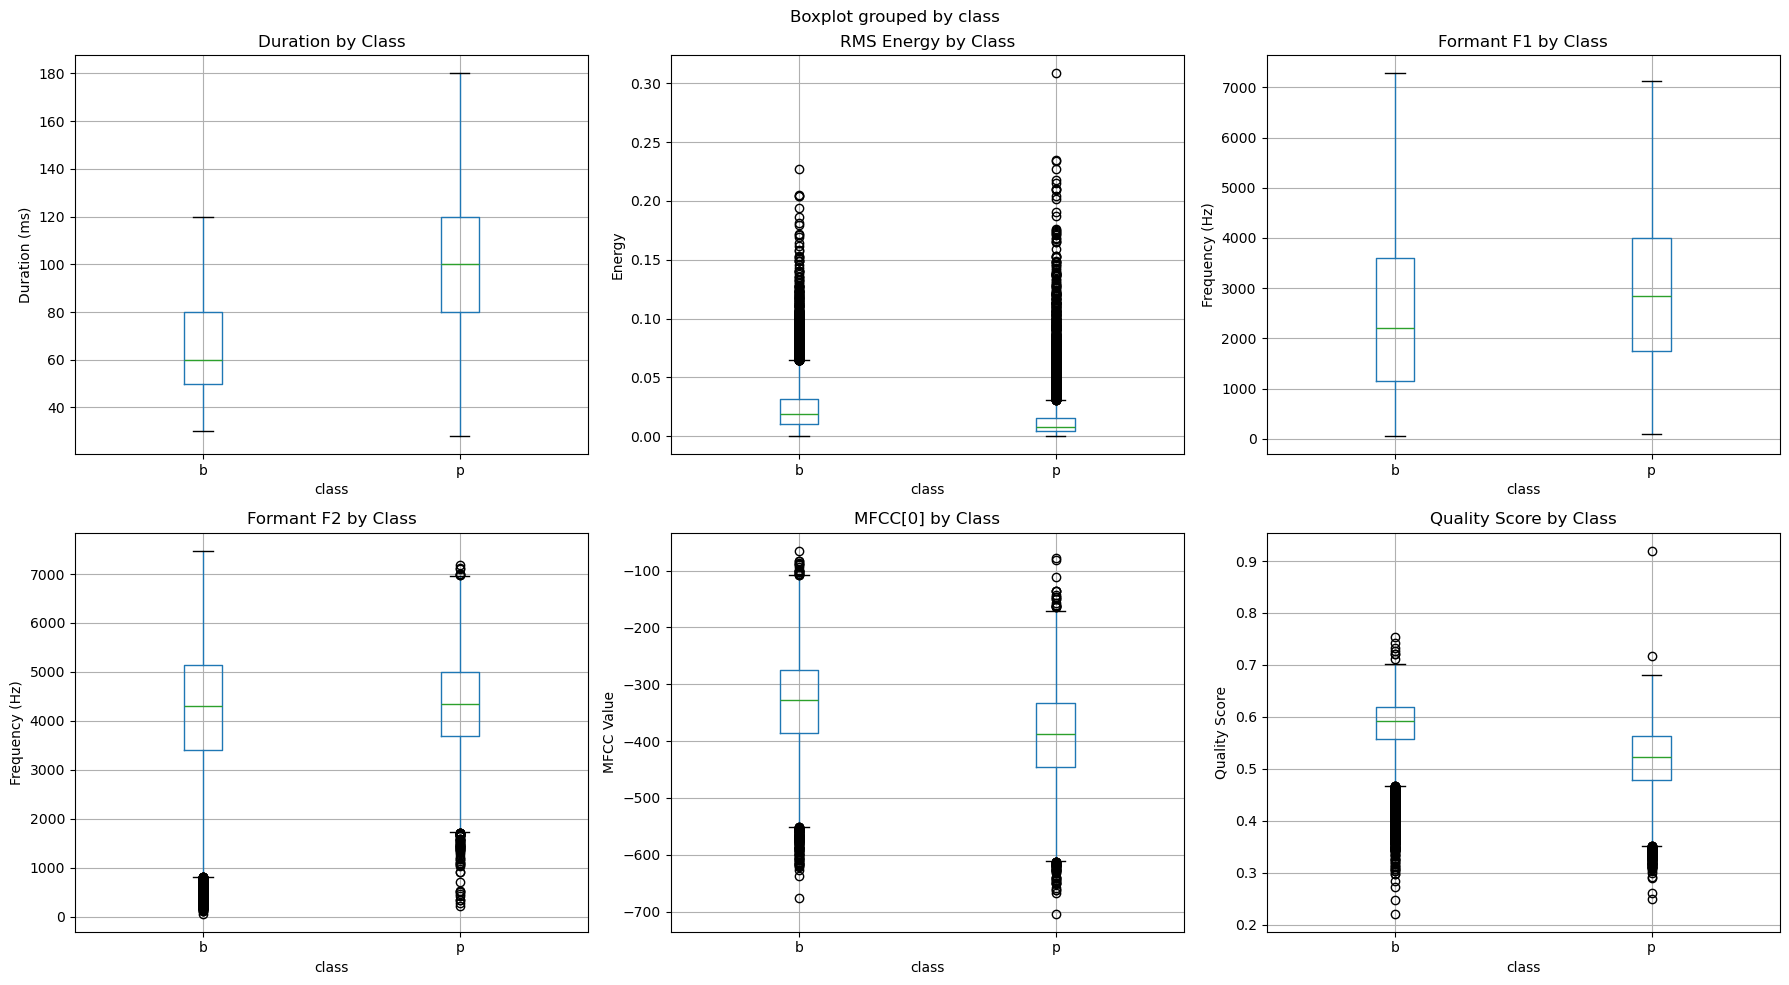

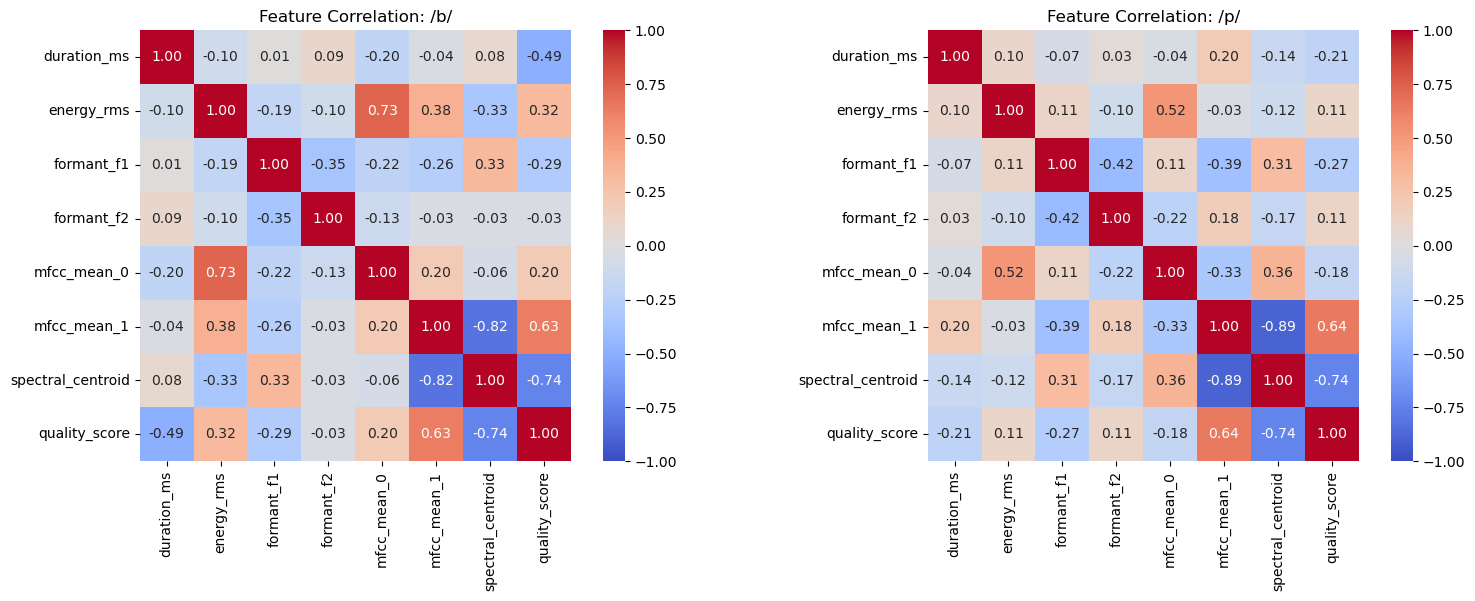


Statistics saved to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/statistics.json


In [8]:
# Final statistics
print("=" * 60)
print("FINAL DATASET STATISTICS")
print("=" * 60)

stats = {
    'total_phonemes': len(df_features),
    'n_b': len(df_features[df_features['class'] == 'b']),
    'n_p': len(df_features[df_features['class'] == 'p']),
    'n_outliers_iso': df_features['is_outlier_iso'].sum(),
    'mean_duration_b': df_features[df_features['class'] == 'b']['duration_ms'].mean(),
    'mean_duration_p': df_features[df_features['class'] == 'p']['duration_ms'].mean(),
    'mean_quality_b': df_features[df_features['class'] == 'b']['quality_score'].mean(),
    'mean_quality_p': df_features[df_features['class'] == 'p']['quality_score'].mean(),
}

for key, value in stats.items():
    if isinstance(value, float):
        print(f"{key}: {value:.2f}")
    else:
        print(f"{key}: {value:,}")

# Visualizations
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Duration comparison
df_features.boxplot(column='duration_ms', by='class', ax=axes[0, 0])
axes[0, 0].set_title('Duration by Class')
axes[0, 0].set_ylabel('Duration (ms)')

# Energy comparison
df_features.boxplot(column='energy_rms', by='class', ax=axes[0, 1])
axes[0, 1].set_title('RMS Energy by Class')
axes[0, 1].set_ylabel('Energy')

# Formant F1 comparison
df_features.boxplot(column='formant_f1', by='class', ax=axes[0, 2])
axes[0, 2].set_title('Formant F1 by Class')
axes[0, 2].set_ylabel('Frequency (Hz)')

# Formant F2 comparison
df_features.boxplot(column='formant_f2', by='class', ax=axes[1, 0])
axes[1, 0].set_title('Formant F2 by Class')
axes[1, 0].set_ylabel('Frequency (Hz)')

# MFCC comparison (first coefficient)
df_features.boxplot(column='mfcc_mean_0', by='class', ax=axes[1, 1])
axes[1, 1].set_title('MFCC[0] by Class')
axes[1, 1].set_ylabel('MFCC Value')

# Quality score comparison
df_features.boxplot(column='quality_score', by='class', ax=axes[1, 2])
axes[1, 2].set_title('Quality Score by Class')
axes[1, 2].set_ylabel('Quality Score')

plt.tight_layout()
plt.show()

# Correlation heatmap for key features
key_features = ['duration_ms', 'energy_rms', 'formant_f1', 'formant_f2', 
                'mfcc_mean_0', 'mfcc_mean_1', 'spectral_centroid', 'quality_score']

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

for idx, phoneme in enumerate(['b', 'p']):
    data = df_features[df_features['class'] == phoneme][key_features].corr()
    sns.heatmap(data, annot=True, fmt='.2f', cmap='coolwarm', center=0, 
                square=True, ax=axes[idx], vmin=-1, vmax=1)
    axes[idx].set_title(f'Feature Correlation: /{phoneme}/')

plt.tight_layout()
plt.show()

# Save statistics
statistics_dict = {
    'dataset_stats': stats,
    'feature_columns': list(df_features.columns),
    'n_features': len(df_features.columns),
    'extraction_params': {
        'MFCC_N_COEFFS': MFCC_N_COEFFS,
        'SPECTROGRAM_WINDOW_MS': SPECTROGRAM_WINDOW_MS,
        'SAMPLE_RATE': SAMPLE_RATE,
        'N_MELS': N_MELS,
    }
}

with open(OUTPUT_DIR / 'statistics.json', 'w') as f:
    json.dump(statistics_dict, f, indent=2, default=str)

print(f"\nStatistics saved to {OUTPUT_DIR / 'statistics.json'}")


## 9. Create Audio Samples for Listening

In [9]:
# Create audio samples directory
audio_samples_dir = OUTPUT_DIR / 'audio_samples'
audio_samples_dir.mkdir(parents=True, exist_ok=True)

def concatenate_audio_samples(df, class_label, n_samples=SAMPLE_SIZE, pause_ms=PAUSE_MS, sr=SAMPLE_RATE):
    """Concatenate audio samples with pauses."""
    # Sample random phonemes
    class_df = df[df['class'] == class_label].sample(n=min(n_samples, len(df[df['class'] == class_label])), random_state=42)
    
    audio_segments = []
    pause_samples = int(pause_ms / 1000 * sr)
    pause_audio = np.zeros(pause_samples)
    
    for idx, row in class_df.iterrows():
        audio_path = row['audio_path']
        if audio_path and Path(audio_path).exists():
            try:
                audio, _ = librosa.load(audio_path, sr=sr, mono=True)
                audio_segments.append(audio)
                audio_segments.append(pause_audio)
            except Exception as e:
                print(f"Error loading {audio_path}: {e}")
    
    if audio_segments:
        # Remove last pause
        if len(audio_segments) > 0 and len(audio_segments[-1]) == pause_samples:
            audio_segments = audio_segments[:-1]
        
        concatenated = np.concatenate(audio_segments)
        return concatenated
    return None

# Create samples for /b/ and /p/
print(f"Creating audio samples ({SAMPLE_SIZE} phonemes per class, {PAUSE_MS}ms pause)...")

audio_b = concatenate_audio_samples(df_merged, 'b', n_samples=SAMPLE_SIZE, pause_ms=PAUSE_MS)
audio_p = concatenate_audio_samples(df_merged, 'p', n_samples=SAMPLE_SIZE, pause_ms=PAUSE_MS)

if audio_b is not None:
    output_path_b = audio_samples_dir / 'b_samples.wav'
    sf.write(output_path_b, audio_b, SAMPLE_RATE)
    print(f"Created {output_path_b} ({len(audio_b)/SAMPLE_RATE:.1f}s)")
    display(Audio(audio_b, rate=SAMPLE_RATE))

if audio_p is not None:
    output_path_p = audio_samples_dir / 'p_samples.wav'
    sf.write(output_path_p, audio_p, SAMPLE_RATE)
    print(f"Created {output_path_p} ({len(audio_p)/SAMPLE_RATE:.1f}s)")
    display(Audio(audio_p, rate=SAMPLE_RATE))


Creating audio samples (20 phonemes per class, 300ms pause)...
Created /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/audio_samples/b_samples.wav (7.0s)


Created /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/audio_samples/p_samples.wav (7.7s)


## 10. Save Results with Optimized Storage System

In [10]:
# Create output directories
features_dir = OUTPUT_DIR / 'features'
features_dir.mkdir(parents=True, exist_ok=True)

print("Saving results...")

# 1. Save filtered phonemes CSV
filtered_csv = OUTPUT_DIR / 'filtered_phonemes.csv'
# Check which columns are available and select only existing ones
requested_cols = ['phoneme_id', 'utterance_id', 'phoneme', 'class', 'start_ms', 'end_ms', 'duration_ms', 'word', 'audio_path']
available_cols = [c for c in requested_cols if c in df_merged.columns]
missing_cols = [c for c in requested_cols if c not in df_merged.columns]
if missing_cols:
    print(f"Warning: Missing columns in df_merged: {missing_cols}")
    # Try to calculate duration_ms from start_ms and end_ms if available
    if 'duration_ms' in missing_cols and 'start_ms' in df_merged.columns and 'end_ms' in df_merged.columns:
        df_merged['duration_ms'] = df_merged['end_ms'] - df_merged['start_ms']
        available_cols.append('duration_ms')
        print(f"Calculated duration_ms from start_ms and end_ms")
df_merged[available_cols].to_csv(filtered_csv, index=False)
print(f"Saved filtered phonemes to {filtered_csv}")

# 2. Prepare features DataFrame for storage
# Flatten nested features (MFCC arrays, etc.)
df_features_flat = df_features.copy()

# Expand MFCC arrays into separate columns
for i in range(MFCC_N_COEFFS):
    if f'mfcc_mean_{i}' not in df_features_flat.columns:
        df_features_flat[f'mfcc_mean_{i}'] = df_features_flat['mfcc_mean'].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else 0.0)
        df_features_flat[f'mfcc_std_{i}'] = df_features_flat['mfcc_std'].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else 0.0)
        df_features_flat[f'delta_mfcc_mean_{i}'] = df_features_flat['delta_mfcc_mean'].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else 0.0)
        df_features_flat[f'delta_mfcc_std_{i}'] = df_features_flat['delta_mfcc_std'].apply(lambda x: x[i] if isinstance(x, np.ndarray) and len(x) > i else 0.0)

# Expand spectral contrast
if 'spectral_contrast_mean' in df_features_flat.columns:
    contrast_data = df_features_flat['spectral_contrast_mean'].apply(lambda x: x if isinstance(x, np.ndarray) else np.zeros(7))
    for i in range(7):
        df_features_flat[f'spectral_contrast_{i}'] = contrast_data.apply(lambda x: x[i] if len(x) > i else 0.0)

# Remove array columns
array_cols = ['mfcc_mean', 'mfcc_std', 'delta_mfcc_mean', 'delta_mfcc_std', 
              'delta2_mfcc_mean', 'delta2_mfcc_std', 'spectral_contrast_mean']
for col in array_cols:
    if col in df_features_flat.columns:
        df_features_flat = df_features_flat.drop(columns=[col])

# 3. Save features in Parquet format
features_parquet = features_dir / 'features.parquet'
df_features_flat.to_parquet(features_parquet, index=False)
print(f"Saved features to {features_parquet}")

# Also save as flat CSV for ML models
features_csv = features_dir / 'features_flat.csv'
df_features_flat.to_csv(features_csv, index=False)
print(f"Saved flat features CSV to {features_csv}")

# 4. Save spectrograms
if SPECTROGRAM_FORMAT == 'h5' and HAS_H5PY:
    spectrograms_h5 = features_dir / 'spectrograms.h5'
    with h5py.File(spectrograms_h5, 'w') as f:
        for phoneme_id, spec in tqdm(spectrograms.items(), desc="Saving spectrograms"):
            if phoneme_id in df_features_flat['phoneme_id'].values:
                f.create_dataset(phoneme_id, data=spec, compression='gzip')
    print(f"Saved spectrograms to {spectrograms_h5}")
elif SPECTROGRAM_FORMAT == 'npy':
    spectrograms_dir = features_dir / 'spectrograms'
    spectrograms_dir.mkdir(parents=True, exist_ok=True)
    for phoneme_id, spec in tqdm(spectrograms.items(), desc="Saving spectrograms"):
        if phoneme_id in df_features_flat['phoneme_id'].values:
            np.save(spectrograms_dir / f"{phoneme_id}.npy", spec)
    print(f"Saved spectrograms to {spectrograms_dir}")

# 5. Create index file
index_data = {
    'metadata': {
        'total_samples': len(df_features_flat),
        'n_b': len(df_features_flat[df_features_flat['class'] == 'b']),
        'n_p': len(df_features_flat[df_features_flat['class'] == 'p']),
        'feature_version': '1.0',
        'extraction_params': {
            'MFCC_N_COEFFS': MFCC_N_COEFFS,
            'SPECTROGRAM_WINDOW_MS': SPECTROGRAM_WINDOW_MS,
            'SAMPLE_RATE': SAMPLE_RATE,
            'N_MELS': N_MELS,
            'HOP_LENGTH': HOP_LENGTH,
        }
    },
    'phonemes': {}
}

# Build phoneme index
for idx, row in df_features_flat.iterrows():
    phoneme_id = row['phoneme_id']
    index_data['phonemes'][phoneme_id] = {
        'class': row['class'],
        'row_index': int(idx),
        'spectrogram_key': phoneme_id,
        'audio_path': str(row.get('audio_path', '')) if 'audio_path' in row else '',
    }

index_file = OUTPUT_DIR / 'index.json'
with open(index_file, 'w') as f:
    json.dump(index_data, f, indent=2, default=str)
print(f"Saved index to {index_file}")

# 6. Save metadata
metadata = {
    'storage_format': STORAGE_FORMAT,
    'spectrogram_format': SPECTROGRAM_FORMAT,
    'filtering_params': {
        'MIN_DURATION_MS': MIN_DURATION_MS,
        'MAX_DURATION_MS': MAX_DURATION_MS,
        'IQR_MULTIPLIER': IQR_MULTIPLIER,
    },
    'feature_extraction_params': {
        'MFCC_N_COEFFS': MFCC_N_COEFFS,
        'SPECTROGRAM_WINDOW_MS': SPECTROGRAM_WINDOW_MS,
        'SAMPLE_RATE': SAMPLE_RATE,
        'N_MELS': N_MELS,
        'HOP_LENGTH': HOP_LENGTH,
    },
    'formant_extraction': 'parselmouth' if HAS_PARSELMOUTH else 'lpc',
}

metadata_file = OUTPUT_DIR / 'metadata.json'
with open(metadata_file, 'w') as f:
    json.dump(metadata, f, indent=2, default=str)
print(f"Saved metadata to {metadata_file}")

print("\n" + "=" * 60)
print("SAVING COMPLETE")
print("=" * 60)
print(f"Output directory: {OUTPUT_DIR}")
print(f"  - Filtered phonemes: {filtered_csv}")
print(f"  - Features (Parquet): {features_parquet}")
print(f"  - Features (CSV): {features_csv}")
if SPECTROGRAM_FORMAT == 'h5' and HAS_H5PY:
    print(f"  - Spectrograms (HDF5): {spectrograms_h5}")
elif SPECTROGRAM_FORMAT == 'npy':
    print(f"  - Spectrograms (NPY): {spectrograms_dir}")
print(f"  - Index: {index_file}")
print(f"  - Metadata: {metadata_file}")
print(f"  - Statistics: {OUTPUT_DIR / 'statistics.json'}")
print(f"  - Audio samples: {audio_samples_dir}")


Saving results...
Saved filtered phonemes to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/filtered_phonemes.csv
Saved features to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/features.parquet
Saved flat features CSV to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/features_flat.csv


Saving spectrograms: 100%|██████████| 35660/35660 [00:17<00:00, 1993.65it/s]


Saved spectrograms to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/spectrograms.h5
Saved index to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/index.json
Saved metadata to /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/metadata.json

SAVING COMPLETE
Output directory: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset
  - Filtered phonemes: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/filtered_phonemes.csv
  - Features (Parquet): /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/features.parquet
  - Features (CSV): /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/features_flat.csv
  - Spectrograms (HDF5): /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/features/spectrograms.h5
  - Index: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/index.json
  - Metadata: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset/metadata.json
  - Statistics: /Volumes/SSanDisk/SpeechRec-Germ

## 11. Examples: Loading Data for Model Training

Examples of how to load the saved data for different types of models.

In [11]:
# Example 1: Load features for ML models (sklearn, xgboost)
print("Example 1: Loading features for ML models")
print("-" * 60)

df_ml = pd.read_parquet(features_dir / 'features.parquet')
X_ml = df_ml.drop(['phoneme_id', 'class'], axis=1, errors='ignore')
y_ml = df_ml['class']

print(f"Features shape: {X_ml.shape}")
print(f"Target shape: {y_ml.shape}")
print(f"Classes: {y_ml.value_counts().to_dict()}")

# Example 2: Load specific phoneme by ID
print("\nExample 2: Loading specific phoneme by ID")
print("-" * 60)

with open(index_file, 'r') as f:
    index = json.load(f)

sample_phoneme_id = list(index['phonemes'].keys())[0]
print(f"Loading phoneme: {sample_phoneme_id}")

row_idx = index['phonemes'][sample_phoneme_id]['row_index']
phoneme_features = df_ml.iloc[row_idx]
print(f"Class: {phoneme_features['class']}")
print(f"Duration: {phoneme_features.get('duration_ms', 'N/A'):.1f}ms")

# Example 3: Load spectrograms for CNN
if SPECTROGRAM_FORMAT == 'h5' and HAS_H5PY:
    print("\nExample 3: Loading spectrograms for CNN")
    print("-" * 60)
    
    with h5py.File(features_dir / 'spectrograms.h5', 'r') as f:
        sample_spec = f[sample_phoneme_id][:]
        print(f"Spectrogram shape: {sample_spec.shape}")
        print(f"Spectrogram dtype: {sample_spec.dtype}")
        print(f"Spectrogram range: [{sample_spec.min():.2f}, {sample_spec.max():.2f}]")
    
    # Batch loading example
    phoneme_ids_batch = list(index['phonemes'].keys())[:5]
    print(f"\nBatch loading {len(phoneme_ids_batch)} spectrograms...")
    with h5py.File(features_dir / 'spectrograms.h5', 'r') as f:
        batch_specs = np.array([f[pid][:] for pid in phoneme_ids_batch])
    print(f"Batch shape: {batch_specs.shape}")

print("\n" + "=" * 60)
print("DATA LOADING EXAMPLES COMPLETE")
print("=" * 60)
print("\nThe dataset is ready for model training!")
print(f"All files are saved in: {OUTPUT_DIR}")


Example 1: Loading features for ML models
------------------------------------------------------------
Features shape: (35660, 110)
Target shape: (35660,)
Classes: {'b': 24917, 'p': 10743}

Example 2: Loading specific phoneme by ID
------------------------------------------------------------
Loading phoneme: dd01c488-10f3-a683-00cf-4d215f4d9b19---de1addcc59c15af5e2cbf4080c8692eb__b__4040_4080
Class: b
Duration: 40.0ms

Example 3: Loading spectrograms for CNN
------------------------------------------------------------
Spectrogram shape: (128, 7)
Spectrogram dtype: float32
Spectrogram range: [-80.00, 0.00]

Batch loading 5 spectrograms...
Batch shape: (5, 128, 7)

DATA LOADING EXAMPLES COMPLETE

The dataset is ready for model training!
All files are saved in: /Volumes/SSanDisk/SpeechRec-German/artifacts/b-p_dataset
